# Assignment 1 - Image Classification

This notebook contains the required task for the first assignment of the Deep Network Development course. Read the task description and implement the empty code cells. Each section represents a stage along implementing an image classifier, from loading and inspecting the dataset to training a **pre-trained** Convolutional Neural Network architecture. The sections are to guide you but you do not have to follow that specific order. 

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [Canvas](https://canvas.elte.hu) or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise training and evaluation can be very slow.

## Rules and Comments
- From the list of datasets and architectures listed in canvas, each student was atributed **1 dataset and 1 architecture** to use within this assignment. Please confirm yours in the Canvas assignment's description. 
- This is an DL class so to pass the homework you do have to implement a working classifier, just loading the data or having a "random-guess" performance is not enough.
- As always, copying others' code will make you fail the homework automatically (and thus the course). 
- **Deadline is October 19**
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
- Please add your name and Neptun ID below for easier identification.

**Name: Eszter Gábor**
**Neptun ID: NHLYN2**
**Project: Fruits360, MobileNetv2**

## Task description
Your task is to train an already pretrained Convolutional Neural Network architecture on a dataset, both given in canvas. The datasets contain images as input and class labels as target, thus you have to solve a Supervised Machine Learning Classification problem. 

The dataset should be divided into train, validation and test set, for which results should be presented for all.

You can either train the architecture you were given without changing its layers, or you can add more layers, if you believe it increases the accuracy. There is no expected percentage of accuracy, but **your accuracy should be better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualisations (any of the following: matplotlib, seaborn, tensorboard, ...) of the accuracy and loss and use Early stopping while training your network.



## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [128]:
import copy

import torch
import torch.utils as utils
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import numpy as np

import time

from torchvision.datasets import ImageFolder

## 1. Dataset 
Load the dataset you were given. Images should be stored in an X variable and your labels in a Y variable. Split your dataset into train, validation and test set and pre-process your data for training.

#### Loading the dataset
Show some images and labels of your dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Apple Apple Banana Banana


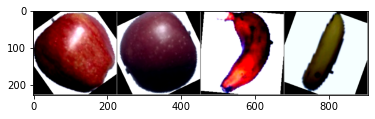

In [129]:
torchvision.datasets.foo
batch_size = 4
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
preprocess = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    ])

datadir = "datasets/fruits360/fruits-360_dataset/fruits-360"

#Datasets
trainset = ImageFolder(datadir + "/Training/subset", transform=preprocess)
validset = None
testset = ImageFolder(datadir + "/Test/subset", transform=preprocess)

#Dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = None
testloader = None

classes = ("Apple", "Avocado", "Banana", "Cauliflower", "Cherry")

def imageShow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
print(' '.join('%5s' % classes[labels[i]] for i in range(batch_size)))
imageShow(torchvision.utils.make_grid(images))

#### Splitting the dataset

In [130]:
valset_size = int(len(testset)*0.5)
testset_size = len(testset) - valset_size
img_datasets = torch.utils.data.random_split(testset, [testset_size, valset_size], generator=torch.Generator().manual_seed(42))

testset = img_datasets[0]
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

validset = img_datasets[1]
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=2)

training_dataloaders = {'train' : trainloader, 'val': validloader}

dataset_sizes = {'train' : len(trainset), 'val' : len(validset)}
print("Dataset sizes:")
print("Training set: ", len(trainset))
print("Valid set: ", len(validset))
print("Test set: ", len(testset))

Dataset sizes:
Training set:  12898
Valid set:  2154
Test set:  2155


#### Pre-processing the dataset

In [131]:
#see @ data loading, preprocess var

print("Training set: ", trainset[0][0].shape)
print("Validation set: ", validset[0][0].shape)
print("Test set: ", testset[0][0].shape)
print("Is CUDA available: ", torch.cuda.is_available())

Training set:  torch.Size([3, 224, 224])
Validation set:  torch.Size([3, 224, 224])
Test set:  torch.Size([3, 224, 224])
Is CUDA available:  True


## 2. Convolutional Neural Network Architecture
Load the CNN architecture you were given using pretrained weights. Define the optimizer and loss function. Train your network and save it. Remember to use Early stopping and show results.

#### Load the architecture

In [132]:
model = models.mobilenet_v2(models.MobileNet_V2_Weights.DEFAULT)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = model.to(device)

cuda


#### Define your optimizer and loss function

In [133]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

#### Train your network

In [134]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        print('Epoch {}/{} LR {:.6f}'.format(epoch, num_epochs - 1, scheduler.get_last_lr()[0]))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in training_dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=4)

Epoch 0/3 LR 0.001000
----------
train Loss: 0.2191 Acc: 0.9282

val Loss: 0.1449 Acc: 0.9540

Epoch 1/3 LR 0.001000
----------
train Loss: 0.0780 Acc: 0.9749

val Loss: 0.1306 Acc: 0.9689

Epoch 2/3 LR 0.001000
----------
train Loss: 0.0652 Acc: 0.9799

val Loss: 0.0383 Acc: 0.9865

Epoch 3/3 LR 0.001000
----------
train Loss: 0.0450 Acc: 0.9857

val Loss: 0.0163 Acc: 0.9940

Training complete in 6m 14s
Best val Acc: 0.993965


#### Show results (accuracy and loss) on training and validation sets

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


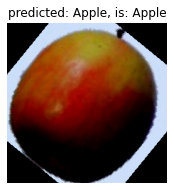

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


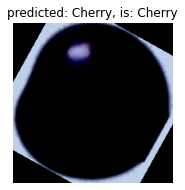

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


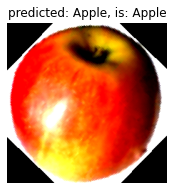

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


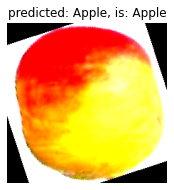

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


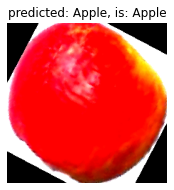

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


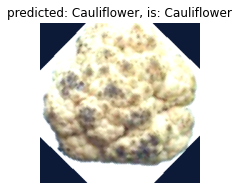

In [146]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(training_dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                fig = plt.figure(figsize=(10,10))
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, is: {}'.format(classes[preds[j]], classes[labels[j]]))
                imageShow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model)

## 3. Conclusion (Evaluation)
Load your trained CNN and evaluate it on the test set. Show some predictions on the test set (3 is enough) by ploting the image and printing the prediction and ground truth.

How good are your results? Do you think the network is overfitted or underfitted? If yes, what do you think lead to that? If not, justify.

#### Evaluate your model

In [169]:
personal_testset = ImageFolder(datadir + "/personal_test_pictures", transform=preprocess)
personal_testloader = torch.utils.data.DataLoader(personal_testset, batch_size=batch_size, shuffle=True, num_workers=2)

def test_model(model, loader, setname):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d %s images: %d %%' % (len(personal_testset), setname,
            100 * correct / total))
test_model(model, personal_testloader, "mixed(personal and fruits360)")
test_model(model, testloader, "provided test")

Accuracy of the network on the 10 mixed(personal and fruits360) images: 60 %
Accuracy of the network on the 10 provided test images: 99 %


#### Show some predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


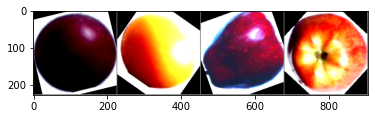

GroundTruth:  Cherry Cherry Apple Apple
Predicted:  Cherry Cherry Apple Apple


In [168]:
dataiterator = iter(testloader)
data = dataiterator.next()
images, labels = data
imageShow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

images, labels = images.to(device), labels.to(device)
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

#### Answer the questions

The results of the model seem to be promising, but only on "sterile" images of fruits, meaning a non-homogenous background will mess up the predictions(see mixed personal/fruits360 results). The model seems to be quite overfitted, but still produces good results on the validation on test sets. After taking a look on the data, the cause might be the presence of overlaps between the 3 sets.